In [106]:
import warnings
import copy
import numpy as np
from IPython.display import display, Image

----
Because we need to somehow manually pair the atoms of both molecules, let's use similar molecules for algorithm validation - Human Insulin vs Insulin LysPro. As can be deducted from its name, LysPro differs in two amino acids.

When implementing the algorithm (and, later, calculating RMSD), we will pair all atoms (except hydrogens) of matching AAs with each other; for positions where AAs are different, we will map with each other only the (heavy) backbone atoms (i.e. ignoring the side chains). 

## 1. Fetch their structures from pdb

...fetches `.cif`, save as `.pdb` using PyMol.
- https://www.rcsb.org/structure/1ZEH
- https://www.rcsb.org/structure/1LPH

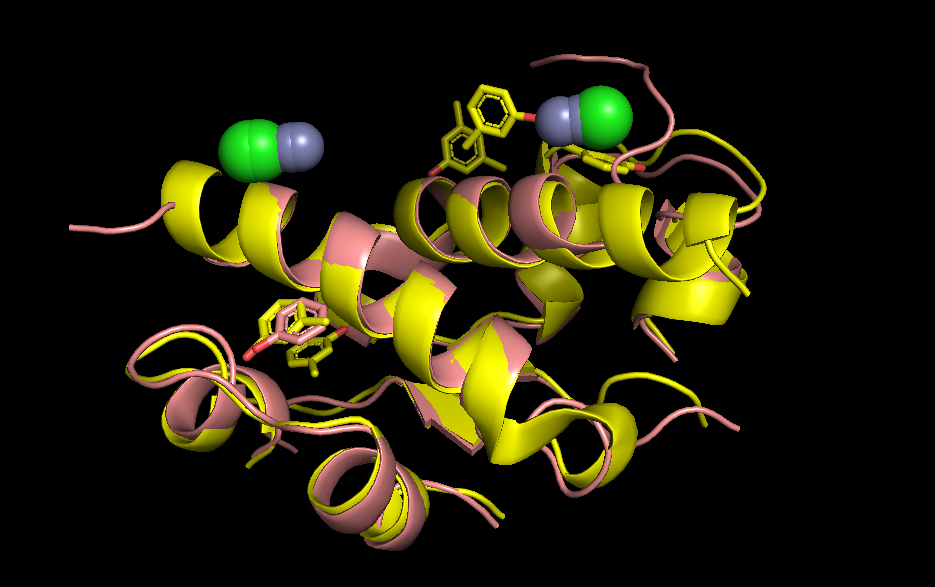

In [5]:
display(Image('img/pymol_view_initial.png'))

(here yellow is Human Insulin, Pink is Insulin LysPro)

## 2. Preprocessing 

The structures already look "aligned", so in order to see results of the algorithms, we will transform one of them. Also, while we are at it, remove Zinc, Cresol and other preservatives, and leave only single chain.

In [31]:
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.PDBIO import PDBIO
from Bio.PDB.PDBIO import Select
parser = PDBParser(PERMISSIVE=1) # ignore some PDB specification problems

filename = '1lph.pdb'
struct_id = '1lph'
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    struct = parser.get_structure(struct_id, filename)
for res in struct.get_residues():
    print(res.get_id(), end=' ')

(' ', 1, ' ') (' ', 2, ' ') (' ', 3, ' ') (' ', 4, ' ') (' ', 5, ' ') (' ', 6, ' ') (' ', 7, ' ') (' ', 8, ' ') (' ', 9, ' ') (' ', 10, ' ') (' ', 11, ' ') (' ', 12, ' ') (' ', 13, ' ') (' ', 14, ' ') (' ', 15, ' ') (' ', 16, ' ') (' ', 17, ' ') (' ', 18, ' ') (' ', 19, ' ') (' ', 20, ' ') (' ', 21, ' ') (' ', 1, ' ') (' ', 2, ' ') (' ', 3, ' ') (' ', 4, ' ') (' ', 5, ' ') (' ', 6, ' ') (' ', 7, ' ') (' ', 8, ' ') (' ', 9, ' ') (' ', 10, ' ') (' ', 11, ' ') (' ', 12, ' ') (' ', 13, ' ') (' ', 14, ' ') (' ', 15, ' ') (' ', 16, ' ') (' ', 17, ' ') (' ', 18, ' ') (' ', 19, ' ') (' ', 20, ' ') (' ', 21, ' ') (' ', 22, ' ') (' ', 23, ' ') (' ', 24, ' ') (' ', 25, ' ') (' ', 26, ' ') (' ', 27, ' ') (' ', 28, ' ') (' ', 29, ' ') (' ', 30, ' ') ('H_ ZN', 31, ' ') (' ', 1, ' ') (' ', 2, ' ') (' ', 3, ' ') (' ', 4, ' ') (' ', 5, ' ') (' ', 6, ' ') (' ', 7, ' ') (' ', 8, ' ') (' ', 9, ' ') (' ', 10, ' ') (' ', 11, ' ') (' ', 12, ' ') (' ', 13, ' ') (' ', 14, ' ') (' ', 15, ' ') (' ', 16, ' ') (' 

We can see that preservatives have non empty first field in their ID (`H_ CL` etc) and true residues have a string of one space...

In [109]:
class SingleMol_RemovePreservatives(Select):
    def accept_residue(self, res):   # "residue"...
        return res.get_id()[0]  == ' '
    def accept_chain(self, chain):
        return chain.get_id() in 'AB'
    
rot = np.array([[-0.62691553,  0.69367306,  0.35467535],   
        [ 0.77836521,  0.57726208,  0.24681187],
        [-0.03353388,  0.43079715, -0.90182553]])
trans =  np.array([  7.31494657, -28.94659109,   1.9758204 ])
    
ids = ['1lph', '1zeh']
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for struct_id in ids:
        filename = struct_id + '.pdb'
        structure = parser.get_structure(struct_id, filename)
        if ids == '1lph':
            structure.transform(rot, trans)

        io_res = PDBIO()
        io_res.set_structure(structure)
        io_res.save(struct_id + '_1m_woP.pdb', SingleMol_RemovePreservatives())

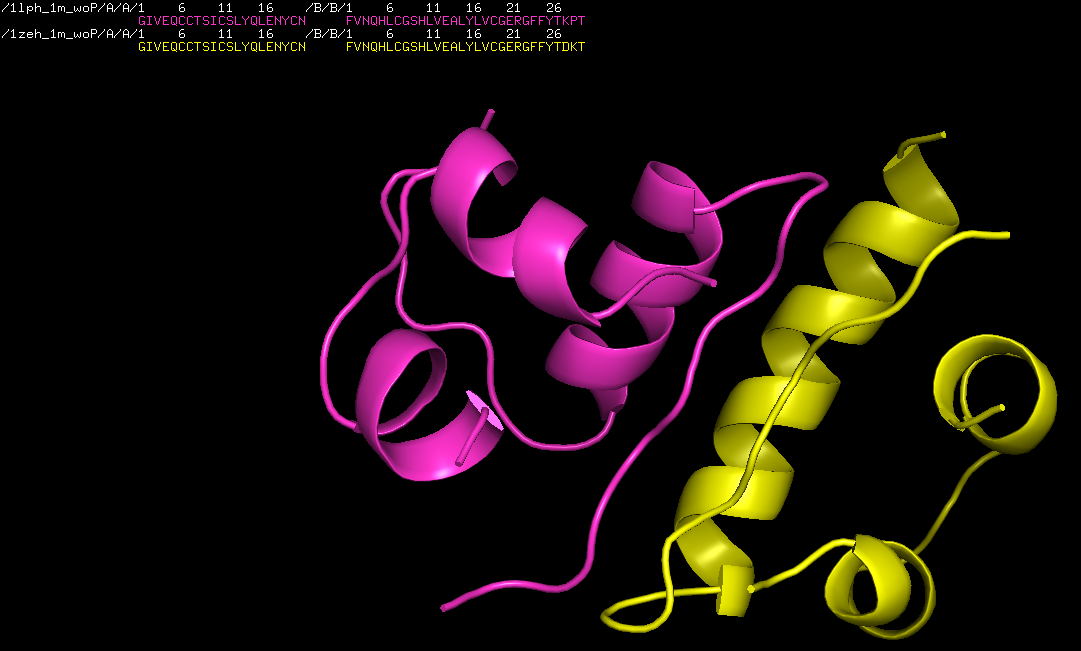

In [110]:
display(Image('img/pymol_view_1m_unaligned.png'))

## 3. Implementation (RMSD included)

In [178]:
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.PDBIO import PDBIO
from Bio.PDB.PDBIO import Select

from scipy.linalg import sqrtm

parser = PDBParser(PERMISSIVE=1) # ignore some PDB specification problems

struct_ids = [
    "1zeh", 
    "1lph",
]
structures = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for s_id in struct_ids:
        filename = s_id + '_1m_woP.pdb'
        structures.append(parser.get_structure(s_id, filename))

In [199]:
def constructPQ(s1, s2):
    """
        Zips through the AA sequences. 
        If Residues on the position j are equal, adds all (matching) atoms
        from Residue; otherwise, adds only backbone atoms.
    """
    
    P = []
    Q = []
    for r1, r2 in zip(s1.get_residues(), s2.get_residues()):
        atms1 = list(r1.get_atoms())
        atms2 = list(r2.get_atoms())
        if r1.get_resname() == r2.get_resname():
            if len(atms1) == len(atms2):
                for a1, a2 in zip(atms1, atms2):  
                    assert a1.name == a2.name
                    P.append(a1.get_coord())
                    Q.append(a2.get_coord())
            else:
                atms2_map = dict()   # for some reason, LysPro structure file has less atoms in 2 AAs
                for a2 in atms2:
                    atms2_map[a2.name] = a2
                for a1 in atms1:
                    if a1.name in atms2_map.keys():
                        P.append(a1.get_coord())
                        Q.append(atms2_map[a1.name].get_coord())
        else:
            for a1, a2 in zip(atms1[:3], atms2[:3]):
                assert a1.name == a2.name and a1.name in ('N', 'CA', 'C')
                P.append(a1.get_coord())
                Q.append(a2.get_coord())
        
    return np.array(P), np.array(Q)

def RMSD(s1, s2):
    P, Q = constructPQ(s1, s2)
    n = len(P)
    return np.sqrt(np.sum((P - Q)**2) / n)

def centroid(vec):
    return vec.mean(axis=0)

def dist(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))

In [210]:
def Kabsch(s1, s2, iterations=5):
    """
        aligns s2 onto s1
    """
    s1 = copy.deepcopy(s1)
    s2 = copy.deepcopy(s2)
    EPS = 1e-5
    
    print('RMSD:')
    r = RMSD(s1, s2)
    print(r)
    
    for i in range(iterations):  
        if r < EPS:
            break
        P, Q = constructPQ(s1, s2)
        
        # rotation
        H = P.T @ Q
        U, Sigma, Vt = np.linalg.svd(H)
        d = np.sign(np.linalg.det(U @ Vt))
        k = np.eye(3)
        k[2][2] = d
        R = Vt.T @ k @ U.T
        R /= np.linalg.det(R)
        s1.transform(np.eye(3), np.zeros(3))
        s2.transform(R, np.zeros(3))
        
        # translation
        P, Q = constructPQ(s1, s2)
        c1 = P.mean(axis=0)
        c2 = Q.mean(axis=0)
        s1.transform(np.eye(3), -c1)
        s2.transform(np.eye(3), -c2)
        r = RMSD(s1, s2)
        print(r)
    return s1, s2

structures_rot = Kabsch(*structures)

from Bio.PDB import PDBIO
files = ['1zeh_rot.pdb', '1lph_rot.pdb']
io = PDBIO()
for file, st in zip(files, structures_rot):
    io.set_structure(st)
    io.save(file)

RMSD:
23.818945723679644
6.455861367253236
5.958613435211693
5.958613435211691
5.958613435211691
5.958613435211693


## 4. Results in PyMol

The blue is Human Insulin.

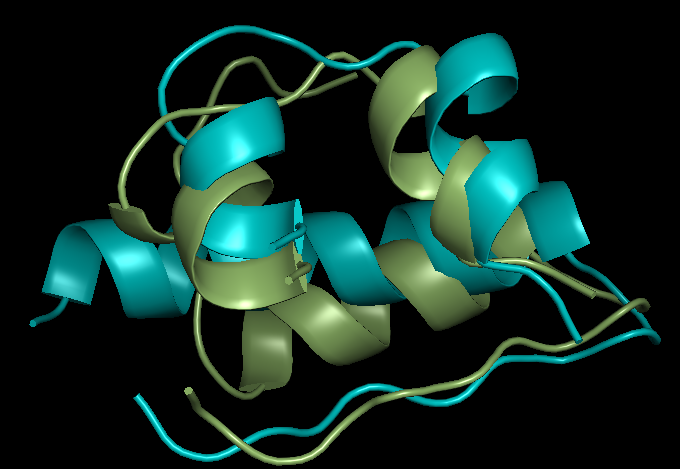

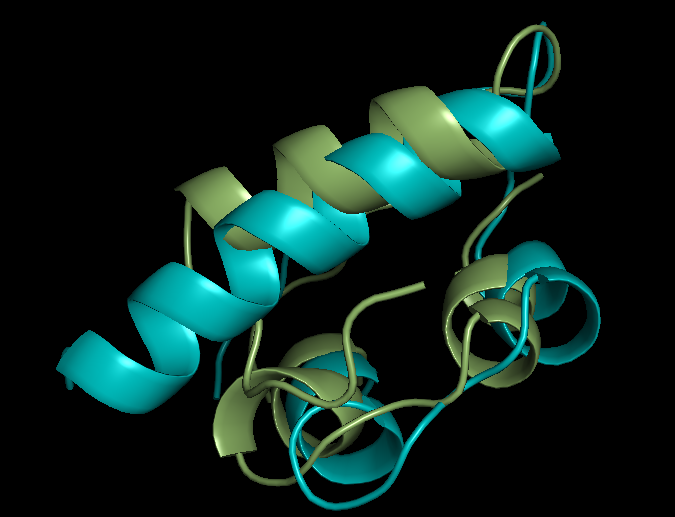

In [212]:
for i in range(2):
    display(Image(f'img/pymol_view_aligned{i+1}.png'))